Import libraries and create model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline

def get_model(input_shape=(120, 160, 3)):
    model = Sequential()

    model.add(BatchNormalization())
    model.add(
        Conv2D(16, (3, 3),
               activation='relu', padding='same', strides=(1, 1),
               input_shape=input_shape)
    )
    model.add(BatchNormalization())
    model.add(
        Conv2D(32, (3, 3), activation='relu')
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.01))
    model.add(Conv2D(48, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    # FC
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(21, activation='softmax', name='steering'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    return model

model = get_model()

Or using donkey model

In [2]:
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
    
def get_model(input_shape=(160, 160, 3)):  # Donkey
    img_in = Input(shape=input_shape, name='input')                        # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name='conv1')(img_in)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name='conv2')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name='conv3')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu', name='conv4')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name='conv5')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='relu', name='dense1')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu', name='dense2')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(21, activation='softmax', name='angle_out')(x)  

    model = Model(inputs=[img_in], outputs=[angle_out])
    model.compile(optimizer='adam',
                  loss={'angle_out': 'categorical_crossentropy'},
                  loss_weights={'angle_out': 0.9}, metrics=['accuracy'])

    return model

model = get_model()

Using TensorFlow backend.


Load training images. If using pretrain model, need to resize the image to correct size otherwise it not working.
Steering is enconded as one hot vector (only one bit one, everything else is 0). In this project I use 21 value to represent steeering as follow:

```
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => Zero angle steering
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => Hard left turn
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => Hard right turn
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] => Right turn 30%
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => Left turn 60%
```

It is possible to use raw angle value to train but you have to change your loss function.


In [16]:
import glob
import json
from keras.preprocessing import image
import numpy as np
from PIL import Image
import os

def load_data(path='./image-hw/'):
    X_train = []
    Y_train = []
    for json_file in glob.iglob(path + '*.json'):
        with open(json_file, 'r') as f:
            data = json.load(f)
            img_file = path + data['image']
            # img = image.load_img(path=img_file, target_size=(120, 160))
            img = Image.open(img_file)
            X_train.append(np.asarray(img.copy(), dtype="uint8"))
            img.close()
            # Create one hot vector to represent steering angle
            a = data['steering'] + 1
            b = round(a / (2/20))
            y = np.zeros(21)
            y[int(b)] = 1
            Y_train.append(y)
            
    return np.array(X_train), np.array(Y_train)
    
X_train, Y_train = load_data('./image-hw/')

In [6]:
X_train_org = X_train
X_train = X_train / 255  # Normalize RGB channels. 0..255 -> 0..1


In [7]:
print(X_train.shape, Y_train.shape)


(3454, 160, 160, 3) (3454, 21)


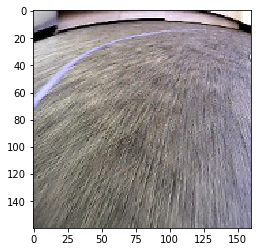

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
# Display some sample image
index = 101
plt.imshow(X_train[index])
plt.show()
print(Y_train[index])

In [1]:
# Only run this when loading presaved model. Otherwise run the block below
from keras.models import load_model
model = load_model('donkey')

Using TensorFlow backend.


In [10]:
history = model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
3454/3454 [==============================] - 31s 9ms/step - loss: 0.2243 - acc: 0.9169
Epoch 2/100
3454/3454 [==============================] - 30s 9ms/step - loss: 0.2195 - acc: 0.9291
Epoch 3/100
3454/3454 [==============================] - 30s 9ms/step - loss: 0.2328 - acc: 0.9186
Epoch 4/100
3454/3454 [==============================] - 30s 9ms/step - loss: 0.1948 - acc: 0.9285
Epoch 5/100
3454/3454 [==============================] - 33s 10ms/step - loss: 0.1809 - acc: 0.9378
Epoch 6/100
3454/3454 [==============================] - 33s 10ms/step - loss: 0.2129 - acc: 0.9236
Epoch 7/100
3454/3454 [==============================] - 30s 9ms/step - loss: 0.2255 - acc: 0.9192
Epoch 8/100
1088/3454 [========>.....................] - ETA: 20s - loss: 0.1985 - acc: 0.9366

KeyboardInterrupt: 

You are done training. You should have add random noise to the data set to prevent over fitting. Verify trainging as follow.

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Verify some prediction with test image

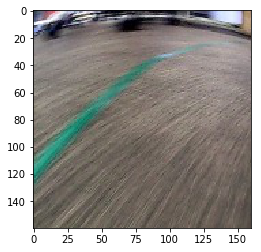

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


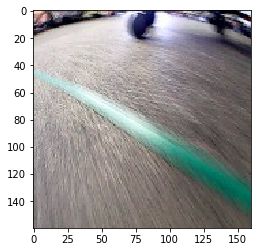

Pred [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


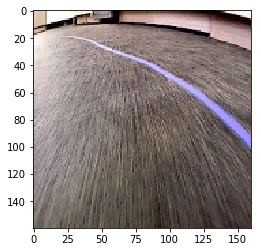

Pred [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


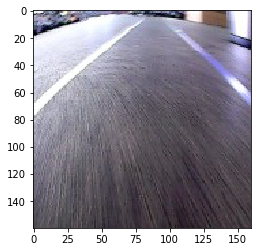

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


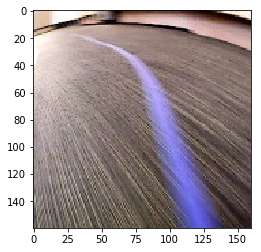

Pred [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


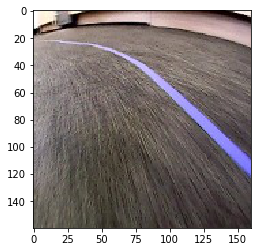

Pred [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


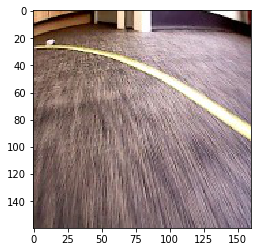

Pred [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


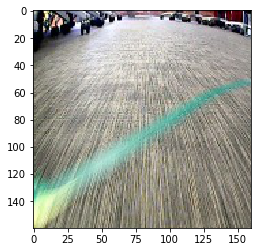

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


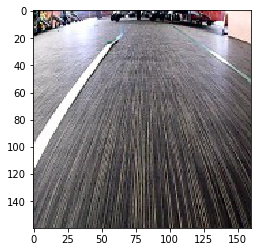

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


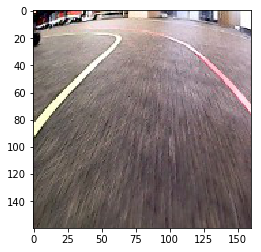

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


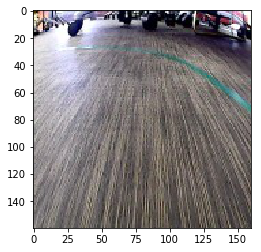

Pred [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


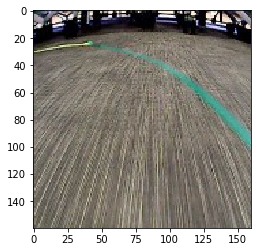

Pred [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


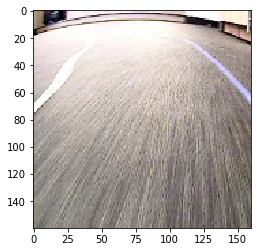

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


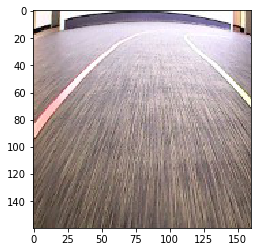

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


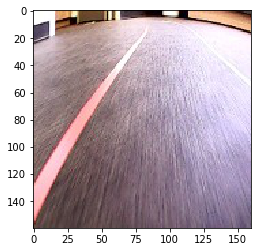

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


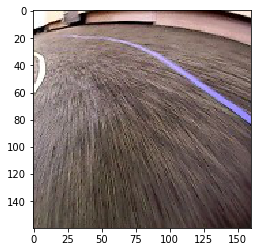

Pred [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


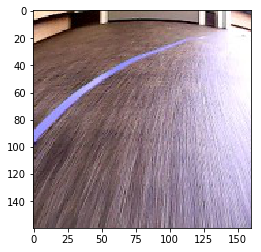

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


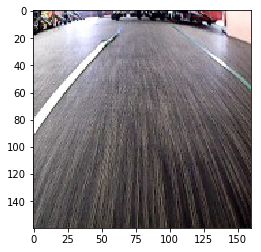

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


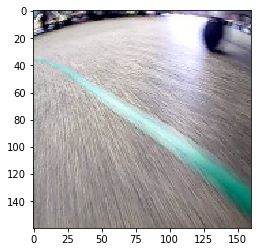

Pred [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


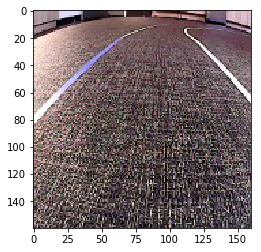

Pred [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
User [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
for index in range(800, 820):
    x = X_test[index]
    pred = model.predict(x.reshape((1,) + x.shape))
    b = np.argmax(pred)
    arr = np.zeros(21)
    arr[b] = 1
    plt.imshow(X_test[index])
    plt.show()
    print('Pred', arr)
    print('User', Y_test[index])

In [17]:
X_test, Y_test = load_data('./image-hw-test/')
model.evaluate(X_test, Y_test)

294/294 [==============================] - 1s 4ms/step


[11.89310374876269, 0.1802721090462743]

When you happy with your model, save it and transfer to the car

In [ ]:
model.save('mymodel.mdl')
# Done

In [95]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 58, 78, 24)        1824      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 27, 37, 32)        19232     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 12, 17, 64)        51264     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 5, 8, 64)          36928     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 3, 6, 64)          36928     
_________________________________________________________________
flattened (Flatten)          (None, 1152)              0         
__________

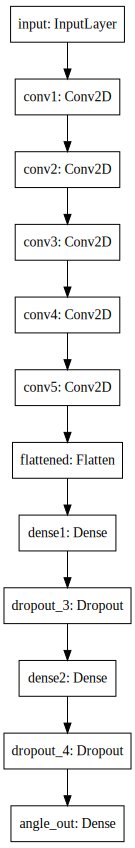

In [22]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
x = X_train[4]

In [9]:
x.shape


(120, 160, 3)

In [11]:
model.save_weights('donky-wg')

In [15]:
model.load_weights('donky-wg')

In [17]:
model.evaluate(X_train, Y_train)

917/917 [==============================] - 2s 2ms/step


[0.008080216559338726, 0.9978189749182116]

In [19]:
model.predict(np.array([X_train[6]]))

array([[2.4473387e-17, 8.6799968e-13, 3.1743054e-14, 1.0432867e-14,
        5.3288285e-12, 2.3990041e-18, 7.3275017e-18, 1.6018547e-16,
        1.7798284e-15, 5.8564139e-16, 1.8548908e-16, 1.2280959e-12,
        2.2715105e-13, 7.1244518e-16, 6.3703265e-10, 2.0252358e-08,
        2.7401397e-11, 2.6852110e-06, 9.9999034e-01, 2.9025057e-06,
        4.1042081e-06]], dtype=float32)

In [18]:
model.save('donkey2-lines.mdl')

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 120, 160, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 78, 24)        1824      
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 37, 32)        19232     
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 17, 64)        51264     
_________________________________________________________________
conv4 (Conv2D)               (None, 5, 8, 64)          36928     
_________________________________________________________________
conv5 (Conv2D)               (None, 3, 6, 64)          36928     
_________________________________________________________________
flattened (Flatten)          (None, 1152)              0         
__________